In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from maskrcnn.preprocess.sample_aoi import aoi_to_chip
from maskrcnn.postprocess.regress import dummy_to_cat, plot_RD

np.random.seed(0)

In [2]:
# clean up dataset
IN_DIR = 'data/Experiment2/Replication/pix_ready.dta'
OUT_RAW_DIR = 'data/Experiment2/Replication/qjt029_pixel.csv'
OUT_FIG_DIR = 'data/Experiment2/Output/'
OUT_NL_DIR = 'data/Experiment2/ambo.csv'
OUT_AOI_DIR = 'data/Experiment2/aoi.csv'

In [3]:
if not os.path.isfile(OUT_RAW_DIR):

    itr = pd.read_stata(IN_DIR, iterator=True)
    df = itr.read()
    df_labels = itr.variable_labels()

    df_s = df.loc[:, [col for col in df.columns if not col.startswith(('did', 'd2im'))]].copy()

    col = dummy_to_cat(df[[col for col in df.columns if col.startswith('did')]])
    col = col.apply(lambda x: df_labels[x].replace('name==', '') if not pd.isnull(x) else np.nan)
    df_s['did'] = col

    col = dummy_to_cat(df[[col for col in df.columns if col.startswith('d2im')]])
    col = col.apply(lambda x: df_labels[x].replace('name==', '') if not pd.isnull(x) else np.nan)
    df_s['d2im'] = col

    df_s.to_csv(OUT_RAW_DIR, index=False)

In [4]:
# replicate Figure 5A and 5B
df = pd.read_csv(OUT_RAW_DIR)
df = df.dropna(subset=['rlaw_highm', 'corrupt_highm'])

model = smf.ols('l0708d ~ lnpd0 + C(d2im)', data=df)
df['l0708d_resid'] = model.fit().resid

df['bdist_signed'] = df['bdist'] * (df['rlaw_highm'] - 0.5) * 2

df['bdist_5kbin'] = pd.cut(df['bdist_signed'],
                           bins=np.linspace(-100, 100, 41),
                           labels=np.linspace(-97.5, 97.5, 40)).astype('float')
df_scatter = df.groupby('bdist_5kbin').agg({'l0708d_resid': 'mean'}).reset_index()

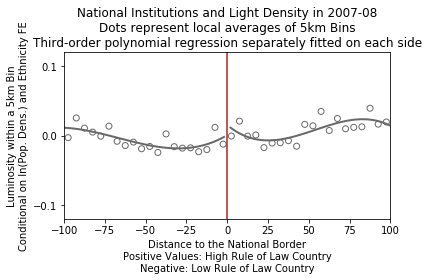

In [5]:
# Figure 5A
plot_RD(
    df=df_scatter,
    x='bdist_5kbin',
    y='l0708d_resid',
    bandwidth=100,
    formula=('l0708d_resid ~ '
             '(bdist_5kbin > 0) * np.abs(bdist_5kbin) + '
             '(bdist_5kbin > 0) * np.power(bdist_5kbin, 2) + '
             '(bdist_5kbin > 0) * np.abs(np.power(bdist_5kbin, 3))'),
    ylim=(-0.12, 0.12),
    yticks=[-0.1, 0, 0.1],
    xlabel=('Distance to the National Border\n'
            'Positive Values: High Rule of Law Country\n'
            'Negative: Low Rule of Law Country'),
    ylabel=('Luminosity within a 5km Bin\n'
            'Conditional on ln(Pop. Dens.) and Ethnicity FE'),
    title=('National Institutions and Light Density in 2007-08\n'
           'Dots represent local averages of 5km Bins\n'
           'Third-order polynomial regression separately fitted on each side'),
    out_dir=os.path.join(OUT_FIG_DIR, 'MP2013Fig5A.pdf'))
plt.show()

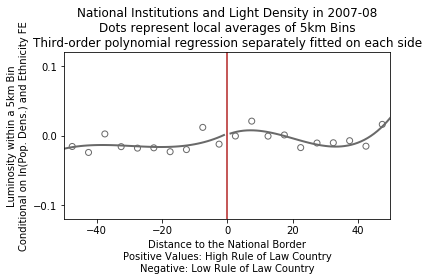

In [6]:
# Figure 5B
plot_RD(
    df=df_scatter,
    x='bdist_5kbin',
    y='l0708d_resid',
    bandwidth=50,
    formula=('l0708d_resid ~ '
             '(bdist_5kbin > 0) * np.abs(bdist_5kbin) + '
             '(bdist_5kbin > 0) * np.power(bdist_5kbin, 2) + '
             '(bdist_5kbin > 0) * np.abs(np.power(bdist_5kbin, 3))'),
    ylim=(-0.12, 0.12),
    yticks=[-0.1, 0, 0.1],
    xlabel=('Distance to the National Border\n'
            'Positive Values: High Rule of Law Country\n'
            'Negative: Low Rule of Law Country'),
    ylabel=('Luminosity within a 5km Bin\n'
            'Conditional on ln(Pop. Dens.) and Ethnicity FE'),
    title=('National Institutions and Light Density in 2007-08\n'
           'Dots represent local averages of 5km Bins\n'
           'Third-order polynomial regression separately fitted on each side'),
    out_dir=os.path.join(OUT_FIG_DIR, 'MP2013Fig5B.pdf'))
plt.show()

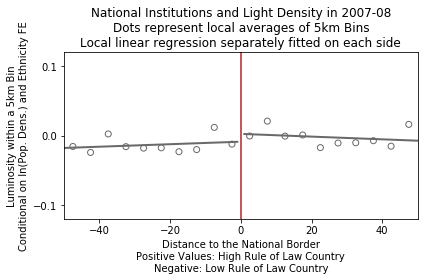

In [7]:
# Figure 5B Linear version
plot_RD(
    df=df_scatter,
    x='bdist_5kbin',
    y='l0708d_resid',
    bandwidth=50,
    formula=('l0708d_resid ~ (bdist_5kbin > 0) * bdist_5kbin'),
    ylim=(-0.12, 0.12),
    yticks=[-0.1, 0, 0.1],
    xlabel=('Distance to the National Border\n'
            'Positive Values: High Rule of Law Country\n'
            'Negative: Low Rule of Law Country'),
    ylabel=('Luminosity within a 5km Bin\n'
            'Conditional on ln(Pop. Dens.) and Ethnicity FE'),
    title=('National Institutions and Light Density in 2007-08\n'
           'Dots represent local averages of 5km Bins\n'
           'Local linear regression separately fitted on each side'),
    out_dir=os.path.join(OUT_FIG_DIR, 'MP2013Fig5B_Linear.pdf'))
plt.show()

In [8]:
# perturb results
df['bdist_1kbin'] = pd.cut(df['bdist_signed'],
                           bins=np.linspace(-50, 50, 101),
                           labels=np.linspace(-49.5, 49.5, 100)).astype('float')
df_scatter = df.groupby('bdist_1kbin').agg({'l0708d_resid': 'mean'}).reset_index()

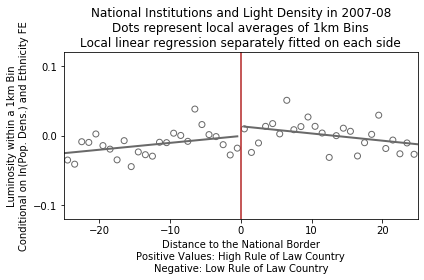

In [9]:
# 1k bin, 25km band
plot_RD(
    df=df_scatter,
    x='bdist_1kbin',
    y='l0708d_resid',
    bandwidth=25,
    formula=('l0708d_resid ~ (bdist_1kbin > 0) * bdist_1kbin'),
    ylim=(-0.12, 0.12),
    yticks=[-0.1, 0, 0.1],
    xlabel=('Distance to the National Border\n'
            'Positive Values: High Rule of Law Country\n'
            'Negative: Low Rule of Law Country'),
    ylabel=('Luminosity within a 1km Bin\n'
            'Conditional on ln(Pop. Dens.) and Ethnicity FE'),
    title=('National Institutions and Light Density in 2007-08\n'
           'Dots represent local averages of 1km Bins\n'
           'Local linear regression separately fitted on each side'),
    out_dir=os.path.join(OUT_FIG_DIR, 'MP2013_Bin1Band25.pdf'))
plt.show()

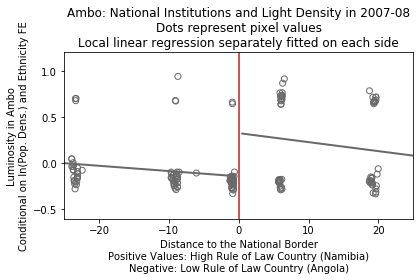

In [10]:
# take subsample
df_sample = (df.loc[(df['bdist_signed'].abs() < 25) & (df['d2im'] == 'AMBO'), :]
             .sort_values(by=['lon', 'lat']).reset_index(drop=True))
plot_RD(
    df=df_sample,
    x='bdist_signed',
    y='l0708d_resid',
    bandwidth=25,
    formula=('l0708d_resid ~ (bdist_signed > 0) * bdist_signed'),
    ylim=(-0.6, 1.2),
    yticks=[-0.5, 0, 0.5, 1],
    xlabel=('Distance to the National Border\n'
            'Positive Values: High Rule of Law Country (Namibia)\n'
            'Negative: Low Rule of Law Country (Angola)'),
    ylabel=('Luminosity in Ambo\n'
            'Conditional on ln(Pop. Dens.) and Ethnicity FE'),
    title=('Ambo: National Institutions and Light Density in 2007-08\n'
           'Dots represent pixel values\n'
           'Local linear regression separately fitted on each side'),
    out_dir=os.path.join(OUT_FIG_DIR, 'MP2013_Ambo.pdf'))
plt.show()

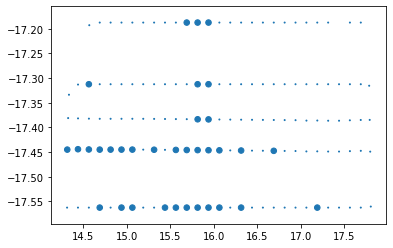

In [11]:
# don't know what they did to their data
# but this is the data that they are using
plt.scatter(df_sample['lon'], df_sample['lat'],
            s=(df_sample['l0708'] > 0) * 30 + 1)
plt.show()

In [12]:
# construct AOI data frame
df_sample['nlgrid'] = df_sample.index
df_sample.to_csv(OUT_NL_DIR, index=False)

# save chip level data
shift_grid = np.linspace(-49.5, 49.5, 100)
df_chip = aoi_to_chip(df=df_sample, indices=['nlgrid'],
                      file_name='NLGRID{:03d}CHIP{:02d}',
                      lon_tile_shifts=np.random.choice(shift_grid, 100),
                      lat_tile_shifts=np.random.choice(shift_grid, 100))
df_chip.to_csv(OUT_AOI_DIR)